In [66]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn.model_selection import train_test_split

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# structure of code largely based on tensorflow tutorial for deep neural nets: https://www.tensorflow.org/get_started/mnist/pros
# see full code of tutorial here: https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_deep.py

In [90]:
## Data ##

def read_file(filename):
    '''
    Parameters
    - filename: str
        File must be tab-delimited as follows: smiles code, tox21_id, label, fingerprint
    
    Returns
    - (X, Y): tuple of np.arrays
        X is an array of features
        Y is a vector of labels
    '''
    X = []
    Y = []
    input_file = open(filename, 'r')
    
    for index, line in enumerate(input_file):
        # split line (1 data point) into smiles, fingerprint (features), and label
        split_line = line.strip().split('\t')
        # print(index)
        smiles = split_line[0]
        fingerprint = [int(c) for c in split_line[3]]
        label = int(split_line[2])
        
        # append data point to train_x (features) and train_y (labels)
        X.append(fingerprint)
        Y.append(label)
    input_file.close()
    return (np.array(X), np.array(Y))

train_filename = './fingerprints/train/nr-ar.fp'
val_filename = './fingerprints/test/nr-ar.fp'
test_filename = './fingerprints/score/nr-ar.fp'
X_train, Y_train = read_file(train_filename)
X_val, Y_val = read_file(val_filename)
X_test, Y_test = read_file(test_filename)

In [89]:
## Model ##

# Notes
# Probability of classifying into the positive class = sigmoid(logit)

def deepnn(x):
    """
    deepnn builds the graph for a deep net for learning the logit

    Args:
        x: an input tensor with the dimensions (batch_size, num_features)

    Returns:
        y: a tensor of length batch_size with values equal to the logits
            of classifying an input data point into the positive class
    """
    # tensorflow dense layer example: https://www.tensorflow.org/tutorials/layers#dense_layer
    
    scale = 0.1
    layer1 = tf.layers.dense(inputs=x, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer2 = tf.layers.dense(inputs=layer1, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer3 = tf.layers.dense(inputs=layer2, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer4 = tf.layers.dense(inputs=layer3, units=1024, activation=tf.nn.relu, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    layer_out = tf.layers.dense(inputs=layer4, units=1, activation=None, kernel_regularizer=tf.contrib.layers.l2_regularizer(scale))
    return tf.squeeze(layer_out)

# sign function
def sign(x):
    return tf.cast(tf.greater_equal(x, 0), tf.int32)

num_features = 881

# input
x = tf.placeholder(tf.float32, [None, num_features])

# Define loss and optimizer
y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}

# Build the graph for the deep net
y_pred = deepnn(x)

# logistic loss, aka sigmoid cross entropy
# y * -log(sigmoid(x)) + (1 - y) * -log(1 - sigmoid(x)), where x is the logit and y is the label
loss_fn = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_labels, logits=y_pred))
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss_fn)

correct_prediction = tf.equal(sign(y_pred), tf.cast(y_labels, tf.int32))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

In [91]:
## Train model ##

# training parameters
batch_size = 50
num_epochs = 3
num_batches_per_epoch = int(np.ceil(len(X_train) / batch_size))

# keep track of loss and accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# accuracy based on initialized weights
val_accuracy = sess.run(accuracy, feed_dict={x: X_val, y_labels: Y_val})
print('initial validation accuracy %0.3g' % val_accuracy)

# training loop
for epoch in range(num_epochs):
    # shuffle indices of training data
    shuffle_indices = np.arange(len(X_train))
    np.random.shuffle(shuffle_indices)

    for i in range(num_batches_per_epoch):
        # get batch
        batch_indices = shuffle_indices[i*batch_size : (i+1)*batch_size]
        batch_x = X_train[batch_indices]
        batch_y = Y_train[batch_indices]

        # train on batch data
        sess.run(train_step, feed_dict={x: batch_x, y_labels: batch_y})

        # store loss and accuracy
        if i % 50 == 0:
            val_accuracy, val_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_val, y_labels: Y_val})
            train_accuracy, train_loss = sess.run([accuracy, loss_fn], feed_dict={x: X_train, y_labels: Y_train})
            val_accs.append(val_accuracy)
            val_losses.append(val_loss)
            train_accs.append(train_accuracy)
            train_losses.append(train_loss)
            print('step %d, train loss: %0.3g,\t val loss: %0.3g,\t val acc: %0.3g\t' % (i, train_loss, val_loss, val_accuracy))

            # save variables only if accuracy has increased
            if val_accuracy > max(val_accs):
                saver.save(sess, 'deepnn_model_weights')

val_accuracy = sess.run(accuracy, feed_dict={x: X_val, y_labels: Y_val})
if val_accuracy > max(val_accs):
    saver.save(sess, 'deepnn_model_weights')

print("Best val accuracy: %g" % max(val_accs))

initial validation accuracy 0.0893
step 0, train loss: 0.577,	 val loss: 0.536,	 val acc: 0.99	
step 50, train loss: 0.123,	 val loss: 0.0745,	 val acc: 0.99	
step 100, train loss: 0.104,	 val loss: 0.0835,	 val acc: 0.986	
step 150, train loss: 0.0964,	 val loss: 0.0781,	 val acc: 0.986	
step 0, train loss: 0.0945,	 val loss: 0.0869,	 val acc: 0.986	
step 50, train loss: 0.0959,	 val loss: 0.102,	 val acc: 0.986	
step 100, train loss: 0.0846,	 val loss: 0.0801,	 val acc: 0.986	
step 150, train loss: 0.0838,	 val loss: 0.0769,	 val acc: 0.99	
step 0, train loss: 0.0788,	 val loss: 0.0725,	 val acc: 0.99	
step 50, train loss: 0.0883,	 val loss: 0.087,	 val acc: 0.99	
step 100, train loss: 0.0722,	 val loss: 0.0776,	 val acc: 0.99	
step 150, train loss: 0.0736,	 val loss: 0.0943,	 val acc: 0.99	
Best val accuracy: 0.989691


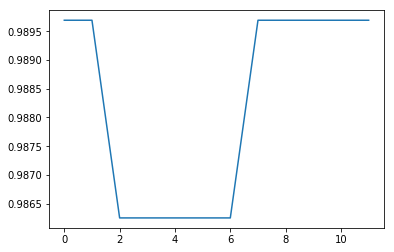

In [100]:
plt.plot(val_accs)

In [99]:
## AUROC

# feed_dict = {x: X_test}
# classification = tf.run(sign(deepnn), feed_dict)
# print classification
y_prob = tf.sigmoid(y_pred)
auroc_fn = tf.metrics.auc(labels=Y_test, predictions=y_prob)
# sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])
auroc = sess.run(auroc_fn, feed_dict={x: X_test})
print(auroc)

FailedPreconditionError: Attempting to use uninitialized value auc_14/false_positives
	 [[Node: auc_14/false_positives/read = Identity[T=DT_FLOAT, _class=["loc:@auc_14/false_positives"], _device="/job:localhost/replica:0/task:0/cpu:0"](auc_14/false_positives)]]

Caused by op 'auc_14/false_positives/read', defined at:
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-99-8f6fcc201b5b>", line 7, in <module>
    auroc_fn = tf.metrics.auc(labels=Y_test, predictions=y_prob)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\metrics_impl.py", line 626, in auc
    labels, predictions, thresholds, weights)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\metrics_impl.py", line 544, in _confusion_matrix_at_thresholds
    false_p = _create_local('false_positives', shape=[num_thresholds])
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\metrics_impl.py", line 196, in _create_local
    validate_shape=validate_shape)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1679, in variable
    caching_device=caching_device, name=name, dtype=dtype)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\variables.py", line 200, in __init__
    expected_shape=expected_shape)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\variables.py", line 319, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 1303, in identity
    result = _op_def_lib.apply_op("Identity", input=input, name=name)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Miniconda3_64\envs\cs221_project_py36x64\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value auc_14/false_positives
	 [[Node: auc_14/false_positives/read = Identity[T=DT_FLOAT, _class=["loc:@auc_14/false_positives"], _device="/job:localhost/replica:0/task:0/cpu:0"](auc_14/false_positives)]]


In [33]:
def compute_saliency_maps(batch_x, batch_y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images, numpy array of shape (N, H, W, 3)
    - y: Labels for X, numpy of shape (N,)
    - model: A SqueezeNet model that will be used to compute the saliency map.

    Returns:
    - saliency: A numpy array of shape (N, H, W) giving the saliency maps for the
    input images.
    """
    num_features = 881
    x = tf.placeholder(tf.float32, [None, num_features])
    y_labels = tf.placeholder(tf.float32, [None]) # domain: {0,1}
    
    y_pred = model(x)
    y_prob = tf.sigmoid(y_pred)
    
    # Compute the score of the correct class for each example.
    # This gives a Tensor with shape [N], the number of examples.
    correct_scores = batch_y*y_prob + (1-batch_y)*(1-y_prob)
    
    saliency_vecs = None
    ###############################################################################
    # TODO: Implement this function. You should use the correct_scores to compute #
    # the loss, and tf.gradients to compute the gradient of the loss with respect #
    # to the input image stored in model.image.                                   #
    # Use the global sess variable to finally run the computation.                #
    # Note: model.image and model.labels are placeholders and must be fed values  #
    # when you call sess.run().                                                   #
    ###############################################################################
    dimage = tf.gradients(correct_scores, x)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        grads = sess.run(dimage, feed_dict={x: batch_x, y_labels: batch_y})[0]
    saliency_vecs = np.array(grads)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency_vecs

In [35]:
saliency_vecs = compute_saliency_maps(X_train, Y_train, deepnn)
print(saliency_vecs.shape)

(9336, 881)


<Container object of 881 artists>

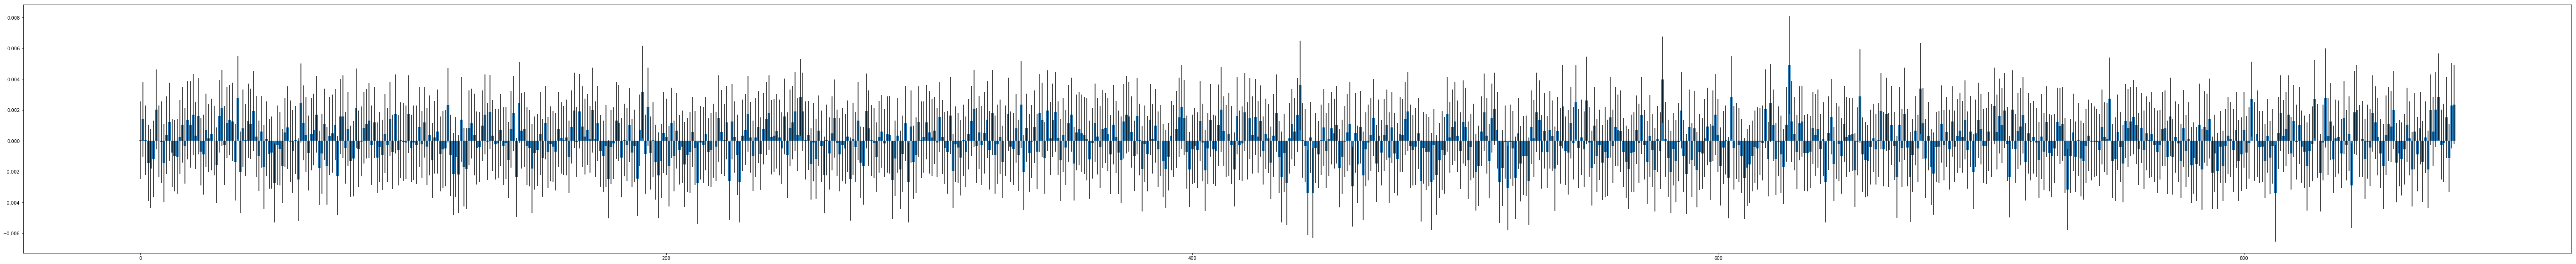

In [36]:
# bar plot (mean + sample standard deviation) of saliency of all features
# see here for meaning of features: ftp://ftp.ncbi.nlm.nih.gov/pubchem/specifications/pubchem_fingerprints.txt
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)
plt.figure(figsize=(100,10))
plt.bar(range(881), mean_saliency, width=1, yerr=stddev_saliency)

Text(0.5,1,'Top 10 predictive features for non-toxicity')

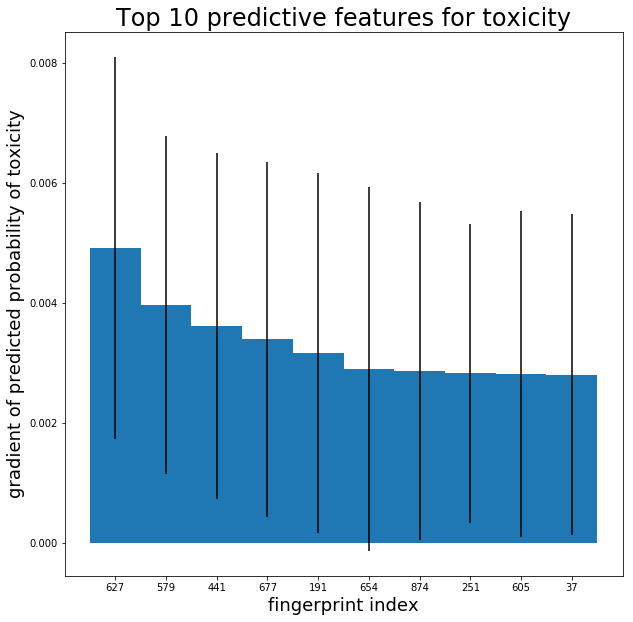

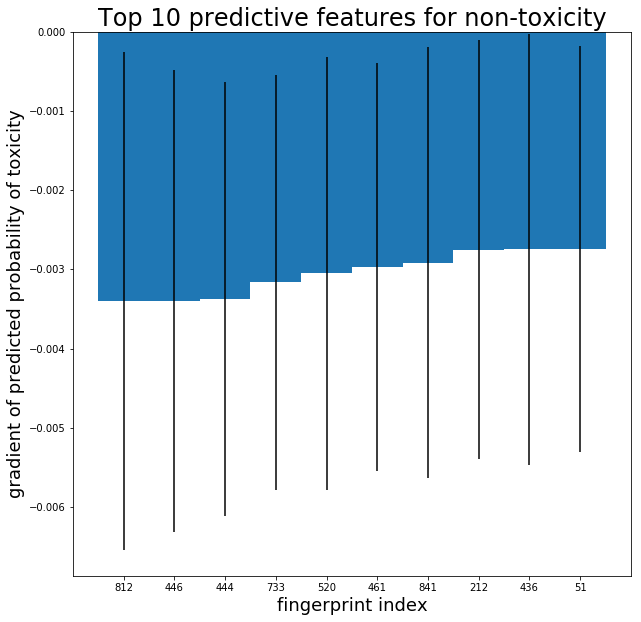

In [49]:
# bar plot (mean + sample standard deviation) of saliency of top n features
n_top = 10
n_bottom = 10
mean_saliency = np.mean(saliency_vecs, axis=0)
stddev_saliency = np.std(saliency_vecs, axis=0, ddof=1)

idx_sort = np.argsort(mean_saliency)

top_ind = idx_sort[-n_top:][::-1]
top_val = mean_saliency[top_ind]
top_std = stddev_saliency[top_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_top), top_val, width=1, yerr=top_std, tick_label=top_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for toxicity', fontsize='24')

bottom_ind = idx_sort[0:n_bottom]
bottom_val = mean_saliency[bottom_ind]
bottom_std = stddev_saliency[bottom_ind]

plt.figure(figsize=(10,10))
plt.bar(range(n_bottom), bottom_val, width=1, yerr=bottom_std, tick_label=bottom_ind)
plt.xlabel('fingerprint index', fontsize='18')
plt.ylabel('gradient of predicted probability of toxicity', fontsize='18')
plt.title('Top 10 predictive features for non-toxicity', fontsize='24')

In [ ]:
sum_saliency = np.sum(saliency_vecs, axis=0)
print(sum_saliency.shape)
print(np.argmax(sum_saliency))
plt.bar(range(881), sum_saliency, 3)